/usr/local/lib/python3.10/dist-packages/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)


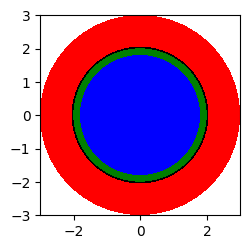

In [9]:
%matplotlib inline
import openmc

uo2 = openmc.Material(1, "uo2")
uo2.add_nuclide('U235', 0.03)
uo2.add_nuclide('U238', 0.97)
uo2.add_nuclide('O16', 2.0)
uo2.set_density('g/cm3', 10.0)

clad = openmc.Material(name="zirconium")
clad.add_element('Zr', 1.0)
clad.set_density('g/cm3', 6.6)

water = openmc.Material(name="h2o")
water.add_nuclide('H1', 2.0)
water.add_nuclide('O16', 1.0)
water.set_density('g/cm3', 1.0)

water.add_s_alpha_beta('c_H_in_H2O')

gas =openmc.Material()
gas.add_element("He",percent=1)
gas.set_density('g/cm3',0.178*10**-3)

reflector_mat = openmc.Material(name='Reflector')
reflector_mat.add_nuclide('Be9', 1.0)
reflector_mat.add_nuclide('O16', 1.0)
reflector_mat.set_density('g/cm3', 2.9)

materials = openmc.Materials([uo2, clad, water, gas, reflector_mat])

"""geometry """
cylinder_fuel = openmc.ZCylinder(r=3, boundary_type = 'vacuum')
cylinder_gap = openmc.ZCylinder(r=2.05)
cylinder_clad = openmc.ZCylinder(r=2)
cylinder_coolant = openmc.ZCylinder(r=1.8)
coolant_cell = openmc.Cell(name="coolant", region=-cylinder_coolant, fill=water)
clad_cell = openmc.Cell(name="clad", region=+cylinder_coolant & -cylinder_clad, fill=clad)
gap_cell = openmc.Cell(name="gap", region=+cylinder_clad & -cylinder_gap, fill=gas)
fuel_cell = openmc.Cell(name="fuel", region=+cylinder_gap & -cylinder_fuel, fill=uo2)
root=openmc.Universe(name="Inverse Pin Cell")
root.add_cells([coolant_cell, clad_cell, gap_cell, fuel_cell])

geometry = openmc.Geometry(root)

root.plot(width=(6,6), color_by='material', colors={uo2:'red', water:'blue', gas:'black', clad:'green'})

batch=100
inactive=20
particles=10000

settings = openmc.Settings()
settings.batches = batch
settings.inactive = inactive
settings.particles = particles

model=openmc.model.Model(geometry, materials, settings)
model.export_to_xml()

In [8]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

/usr/local/lib/python3.10/dist-packages/openmc/mixin.py:70: IDWarning: Another Cell instance already exists with id=200.
  warn(msg, IDWarning)
/usr/local/lib/python3.10/dist-packages/openmc/mixin.py:70: IDWarning: Another Surface instance already exists with id=300.
  warn(msg, IDWarning)
/usr/local/lib/python3.10/dist-packages/openmc/mixin.py:70: IDWarning: Another Surface instance already exists with id=301.
  warn(msg, IDWarning)
/usr/local/lib/python3.10/dist-packages/openmc/mixin.py:70: IDWarning: Another Surface instance already exists with id=303.
  warn(msg, IDWarning)
/usr/local/lib/python3.10/dist-packages/openmc/mixin.py:70: IDWarning: Another Surface instance already exists with id=304.
  warn(msg, IDWarning)
/usr/local/lib/python3.10/dist-packages/openmc/mixin.py:70: IDWarning: Another Surface instance already exists with id=400.
  warn(msg, IDWarning)
/usr/local/lib/python3.10/dist-packages/openmc/mixin.py:70: IDWarning: Another Surface instance already exists with id=40

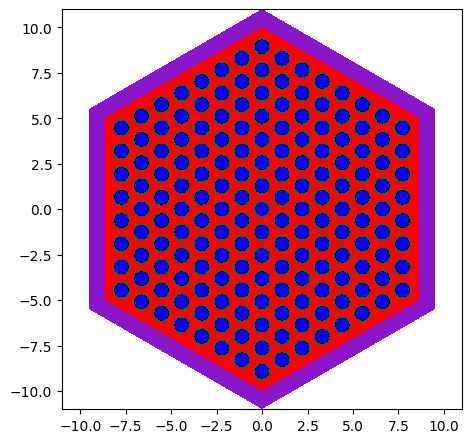

In [20]:
# Geometry definitions

# Boudries and outer universe
all_fuel_out=openmc.Cell(cell_id=200, fill=uo2)

# Top & bottom of the assembly 
assembly_z0 = openmc.ZPlane(surface_id=300, z0=-75)
assembly_z1 = openmc.ZPlane(surface_id=301, z0=75)
assembly = openmc.model.hexagonal_prism(edge_length=10, orientation='y')

# Top & bottom of the reflector
reflector_z0 = openmc.ZPlane(surface_id=303, z0=-95, boundary_type='vacuum')
reflector_z1 = openmc.ZPlane(surface_id=304, z0= 95, boundary_type='vacuum')

# Reflector hexagon
reflector = openmc.model.hexagonal_prism(edge_length=11, orientation='y',
    boundary_type='vacuum')

assembly_cell = openmc.Cell()
reflect_cell = openmc.Cell()
top_reflect_cell = openmc.Cell()
bot_reflect_cell = openmc.Cell()

assembly_cell.region = assembly & -assembly_z1 & +assembly_z0

reflect_cell.region = ~assembly & reflector \
& -assembly_z1 & +assembly_z0

top_reflect_cell.region = reflector & +assembly_z1 & -reflector_z1

bot_reflect_cell.region = reflector & -assembly_z0 & +reflector_z0

reflect_cell.fill = reflector_mat
top_reflect_cell.fill = reflector_mat
bot_reflect_cell.fill = reflector_mat

# Create universes
all_fuel_out_u=openmc.Universe(cells=[all_fuel_out])
u_reflect = openmc.Universe(cells=(reflect_cell,top_reflect_cell,bot_reflect_cell))
u_root = openmc.Universe()

coolant_or1 = openmc.ZCylinder(surface_id=400, r=0.3765)
clad_ir1 = openmc.ZCylinder(surface_id=401, r=0.4)
clad_or1 = openmc.ZCylinder(surface_id=402, r=0.465)

coolant_region1 = -coolant_or1 & -assembly_z1 & +assembly_z0
clad_region1 = +coolant_or1 & -clad_or1 & -assembly_z1 & +assembly_z0

fuel_region1 = +clad_or1 & -assembly_z1 & +assembly_z0 

coolant_cell1  = openmc.Cell(cell_id=400, fill=water, region=coolant_region1)
clad_cell1  = openmc.Cell(cell_id=401, fill=clad, region=clad_region1)
fuel_cell1 = openmc.Cell(cell_id=402, fill=uo2, region=fuel_region1)

central_tube_u = openmc.Universe(cells=[coolant_cell1, clad_cell1, fuel_cell1])

coolant_or2 = openmc.ZCylinder(surface_id=410, r=0.3765)
clad_ir2 = openmc.ZCylinder(surface_id=411, r=0.4)
clad_or2 = openmc.ZCylinder(surface_id=412, r=0.465)

coolant_region2 = -coolant_or2 & -assembly_z1 & +assembly_z0
gap_region2  = +coolant_or2 & -clad_ir2 & -assembly_z1 & +assembly_z0
clad_region2 = +clad_ir2 & -clad_or2 & -assembly_z1 & +assembly_z0

fuel_region2 = +clad_or2 & -assembly_z1 & +assembly_z0 

coolant_cell2  = openmc.Cell(cell_id=410, fill=water,   region=coolant_region2)
gap_cell2   = openmc.Cell(cell_id=411, fill=gas, region=gap_region2)
clad_cell2  = openmc.Cell(cell_id=412, fill=clad,  region=clad_region2)
fuel_cell2 = openmc.Cell(cell_id=413, fill=uo2,  region=fuel_region2)

au13_u = openmc.Universe(cells=[fuel_cell2, gap_cell2, clad_cell2, coolant_cell2])

coolant_or3 = openmc.ZCylinder(surface_id=420, r=0.3765)
clad_ir3 = openmc.ZCylinder(surface_id=421, r=0.4)
clad_or3 = openmc.ZCylinder(surface_id=422, r=0.465)

coolant_region3 = -coolant_or3 & -assembly_z1 & +assembly_z0
gap_region3  = +coolant_or3 & -clad_ir3 & -assembly_z1 & +assembly_z0
clad_region3 = +clad_ir3 & -clad_or3 & -assembly_z1 & +assembly_z0

fuel_region3 = +clad_or3 & -assembly_z1 & +assembly_z0 

coolant_cell3  = openmc.Cell(cell_id=420, fill=water,   region=coolant_region3)
gap_cell3   = openmc.Cell(cell_id=421, fill=gas, region=gap_region3)
clad_cell3  = openmc.Cell(cell_id=422, fill=clad,  region=clad_region3)
water_cell3 = openmc.Cell(cell_id=423, fill=uo2,  region=fuel_region3)

au22_u = openmc.Universe(cells=[coolant_cell3, gap_cell3, clad_cell3, water_cell3])

# Geometry of av5 rod

coolant_or4 = openmc.ZCylinder(surface_id=430, r=0.3765)
clad_ir4 = openmc.ZCylinder(surface_id=431, r=0.4)
clad_or4 = openmc.ZCylinder(surface_id=432, r=0.465)

coolant_region4 = -coolant_or4 & -assembly_z1 & +assembly_z0
gap_region4  = +coolant_or4 & -clad_ir4 & -assembly_z1 & +assembly_z0
clad_region4 = +clad_ir4 & -clad_or4 & -assembly_z1 & +assembly_z0

fuel_region4 = +clad_or4 & -assembly_z1 & +assembly_z0 

coolant_cell4  = openmc.Cell(cell_id=430, fill=water,    region=coolant_region4)
gap_cell4   = openmc.Cell(cell_id=431, fill=gas, region=gap_region4)
clad_cell4  = openmc.Cell(cell_id=432, fill=clad,  region=clad_region4)
fuel_cell4 = openmc.Cell(cell_id=433, fill=uo2,  region=fuel_region4)

av5_u = openmc.Universe(cells=[coolant_cell4, gap_cell4, clad_cell4, fuel_cell4])

# Geometry of awu rod

coolant_or5 = openmc.ZCylinder(surface_id=440, r=0.3765)
clad_ir5 = openmc.ZCylinder(surface_id=441, r=0.4)
clad_or5 = openmc.ZCylinder(surface_id=442, r=0.465)

coolant_region5 = -coolant_or5 & -assembly_z1 & +assembly_z0
gap_region5  = +coolant_or5 & -clad_ir5 & -assembly_z1 & +assembly_z0
clad_region5 = +clad_ir5 & -clad_or5 & -assembly_z1 & +assembly_z0

fuel_region5 = +clad_or5 & -assembly_z1 & +assembly_z0 

coolant_cell5  = openmc.Cell(cell_id=440, fill=water, region=coolant_region5)
gap_cell5   = openmc.Cell(cell_id=441, fill=gas,   region=gap_region5)
clad_cell5  = openmc.Cell(cell_id=442, fill=clad,    region=clad_region5)
fuel_cell5 = openmc.Cell(cell_id=443, fill=uo2,    region=fuel_region5)

awu_u = openmc.Universe(cells=[coolant_cell5, gap_cell5, clad_cell5, fuel_cell5])



# Geometry of go rod

coolant_or6 = openmc.ZCylinder(surface_id=450, r=0.3765)
clad_ir6 = openmc.ZCylinder(surface_id=451, r=0.4)
clad_or6 = openmc.ZCylinder(surface_id=452, r=0.465)

coolant_region6 = -coolant_or6 & -assembly_z1 & +assembly_z0
gap_region6  = +coolant_or6 & -clad_ir6 & -assembly_z1 & +assembly_z0
clad_region6 = +clad_ir6 & -clad_or6 & -assembly_z1 & +assembly_z0

fuel_region6 = +clad_or6 & -assembly_z1 & +assembly_z0 

coolant_cell6  = openmc.Cell(cell_id=450, fill=water, region=coolant_region6)
gap_cell6   = openmc.Cell(cell_id=451, fill=gas,  region=gap_region6)
clad_cell6  = openmc.Cell(cell_id=452, fill=clad,   region=clad_region6)
fuel_cell6 = openmc.Cell(cell_id=453, fill=water,   region=fuel_region6)

go_u = openmc.Universe(cells=[fuel_cell6, gap_cell6, clad_cell6, coolant_cell6])



# Creating the hexagonal lattice

lat=openmc.HexLattice(name='assembly')
lat.center = (0., 0.)
lat.pitch = (1.275,)
lat.outer=all_fuel_out_u

ring7=[awu_u, awu_u, awu_u,awu_u, awu_u, awu_u, awu_u]*6
ring6= [au22_u, av5_u, au22_u,
        av5_u, au22_u, av5_u,
        au13_u,av5_u, au22_u,
        av5_u,au22_u,av5_u,
        au22_u,av5_u,au22_u,
        av5_u,au22_u,av5_u,
        au22_u,av5_u,au22_u,
        av5_u,au22_u,av5_u,
        au13_u,av5_u,au22_u,
        av5_u,au22_u,av5_u,
        au13_u,av5_u,au22_u,
        av5_u,au22_u,av5_u]
ring5= [au13_u, au13_u, au22_u, au13_u, au13_u]*6
ring4=[au22_u, av5_u, au13_u, av5_u]*6
ring3=[au13_u, au22_u, au13_u]*6
ring2=[au22_u, av5_u]*6
ring1=[au13_u]*6
ring0=[central_tube_u]
lat.universes = [ring7, ring6, ring5, ring4, ring3, ring2, ring1, ring0]
lat.orientation='y'
assembly_cell.fill = lat

u_root.add_cells([assembly_cell, reflect_cell, top_reflect_cell, bot_reflect_cell])
geom=openmc.Geometry(u_root)
geom.export_to_xml()

u_root.plot(origin=(0,0,0),width=(22,22),color_by='material',colors={water:'blue', uo2:'red', gas:'black', clad:'green'},pixels=[400,400])

In [21]:
# OpenMC simulation parameters

batches = 100
inactive = 10
particles = 5000

settings = openmc.Settings()
settings.batches = batches
settings.inactive = inactive
settings.particles = particles

uniform_dist = openmc.stats.Box([-24,-24,-75],[24,24,75],only_fissionable=True)
settings.source = openmc.source.Source(space=uniform_dist)

settings.export_to_xml()

In [22]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################